In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torchvision
from torch.utils.data import Dataset, ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt

import torchvision.datasets as datasets

import warnings
warnings.filterwarnings("ignore")

The above code block was added to silence a user warning for a deprecated function. It can be seen below.
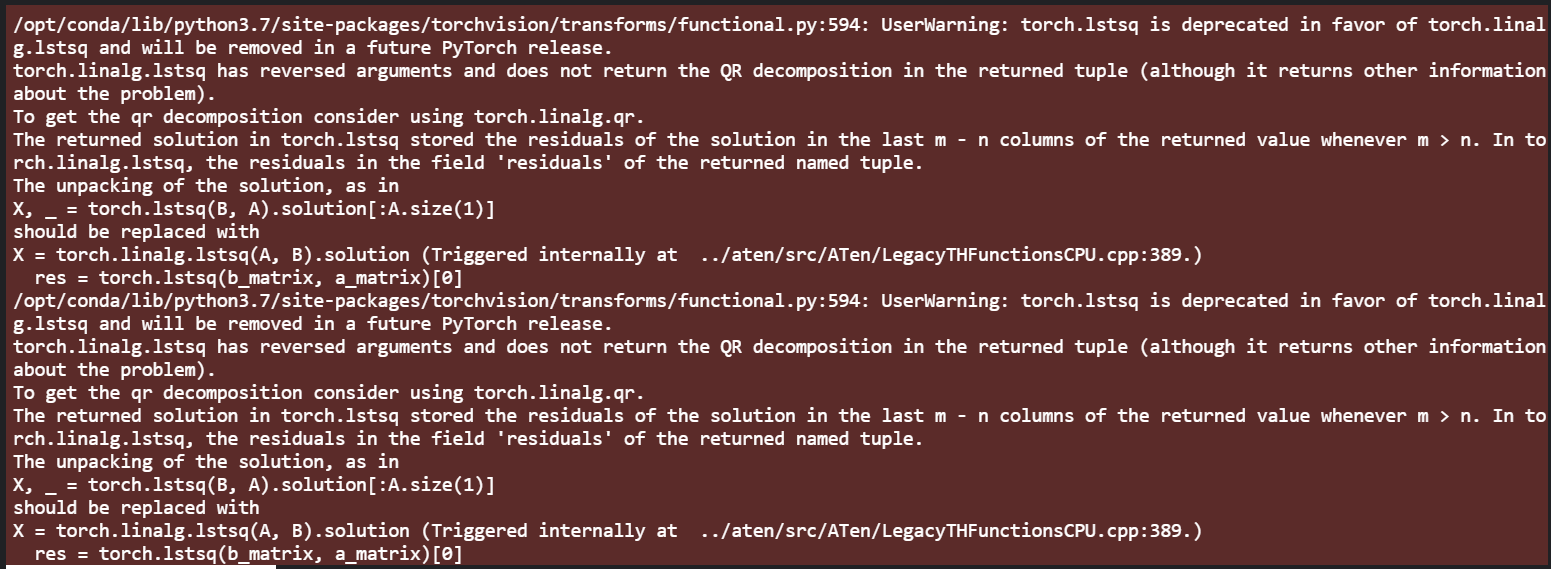
The code was found at: https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings

In [3]:
#calc_t = transforms.Compose(
#    [transforms.Resize((300,300)),
#     transforms.ToTensor()])
#
#train_dir = '../input/edible-or-harmful-plant-dataset/Edible or Harmful/train'
#calc_set = ImageFolder(root=train_dir, transform=calc_t)
#
#calcloader = torch.utils.data.DataLoader(calc_set, batch_size=64,
#                                          shuffle=True, num_workers=2)

This creates the dataloader needs to calculate the mean and mode needed to normalize my dataset.

In [4]:
#def get_mean_and_std(dataloader):
#    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
#    for data, _ in dataloader:
#        # Mean over batch, height and width, but not over the channels
#        channels_sum += torch.mean(data, dim=[0,2,3])
#        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
#        num_batches += 1
#    
#    mean = channels_sum / num_batches
#
#    # std = sqrt(E[X^2] - (E[X])^2)
#    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
#
#    return mean, std

Class get_mean_and_std was encorporated into my code from https://towardsdatascience.com/how-to-calculate-the-mean-and-standard-deviation-normalizing-datasets-in-pytorch-704bd7d05f4c.
My contribution was to change the input from CIFAR to my own database.

In [5]:
#print (get_mean_and_std(calcloader))

(tensor([0.4160, 0.4336, 0.2976]), tensor([0.2561, 0.2339, 0.2662]))
To save computatational time, this code was commented out.

In [6]:
original_t = transforms.Compose(
    [transforms.Resize((200,200)),
     transforms.ToTensor(),
     transforms.Normalize((0.4159, 0.4335, 0.2976), (0.2561, 0.2338, 0.2660))])

flipped = transforms.Compose(
    [transforms.Resize((200,200)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(10),
     transforms.ToTensor(),
     transforms.Normalize((0.4159, 0.4335, 0.2976), (0.2561, 0.2338, 0.2660))])

tripped = transforms.Compose(
    [transforms.Resize((200,200)),
     transforms.RandomVerticalFlip(),
     transforms.RandomRotation(10),
     transforms.ToTensor(),
     transforms.Normalize((0.4159, 0.4335, 0.2976), (0.2561, 0.2338, 0.2660))])

In [7]:
skipped = transforms.Compose(
    [transforms.Resize((200,200)),
     transforms.RandomPosterize(bits=2),
     transforms.ColorJitter(brightness=0.9, contrast=0.9),
     #transforms.RandomAdjustSharpness(sharpness_factor=3),
     transforms.ToTensor(),
     transforms.Normalize((0.4159, 0.4335, 0.2976), (0.2561, 0.2338, 0.2660))])

hipped = transforms.Compose(
    [transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
     transforms.Resize((100,100)),
     transforms.ToTensor(),
     transforms.Normalize((0.4159, 0.4335, 0.2976), (0.2561, 0.2338, 0.2660))])

dipped = transforms.Compose(
    [transforms.Resize((200,200)),
     transforms.RandomEqualize(),
     transforms.RandomRotation(10),
     transforms.ToTensor(),
     transforms.Normalize((0.4159, 0.4335, 0.2976), (0.2561, 0.2338, 0.2660))])

Attempted transformations that are dormant.

In [8]:
batch_size = 128 

valid_dir = '../input/edible-or-harmful-plant-dataset/Edible or Harmful/valid'
test_dir = '../input/edible-or-harmful-plant-dataset/Edible or Harmful/test'
train_dir = '../input/edible-or-harmful-plant-dataset/Edible or Harmful/train'

o_set = ImageFolder(root=train_dir, transform=original_t)
test_set = ImageFolder(root=test_dir, transform=original_t)
valid_set = ImageFolder(root=valid_dir, transform=original_t)


f_set=ImageFolder(root=train_dir, transform=flipped)
t_set=ImageFolder(root=train_dir, transform=tripped)
s_set=ImageFolder(root=train_dir, transform=skipped)
h_set=ImageFolder(root=train_dir, transform=hipped)
d_set=ImageFolder(root=train_dir, transform=dipped)

train_set = ConcatDataset([o_set,f_set,t_set])#d_set,s_set,h_set])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
#
validloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
#
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('Alfalfa', 'Allium', 'Blue Vervain', 'Borage', 'Broadleaf Plantain', 'Bull Thistle', 'Burdock', 'Calendula', 'castor_oil_plant',
           'Cattail', 'Chickweed', 'Chicory', 'Chive Blossom', 'Cleavers', 'Coltsfoot', 'Common Mallow', 'Common Milkweed', 'Common Sow Thistle', 'Common Vetch',
           'Common Yarrow', 'Coneflower', 'Cow Parsley', 'Cowslip', 'Creeping Charlie', 'Crimson Clover', 'Crithmum Maritimum', 'Curly Dock', 'Daisy Fleabane', 'Dandellion',
           'dieffenbachia', 'Downy Yellow Violet', 'Elderberry', 'Evening Primrose', 'Fennel', 'Fern Leaf Yarrow', 'Field Pennycress', 'Fireweed', 'Forget Me Not', 'foxglove',
           'Gardenia', 'Garlic Mustard', 'Geranium', 'Ground Ivy', 'Harebell', 'Henbit', 'Herb Robert', 'Japanese Knotweed', 'Joe Pye Weed', 'Knapweed',
           'Kudzu', 'Lambs Quarters', 'lilies', 'lily_of_the_valley', 'Mallow', 'Mayapple', 'Meadowsweet', 'Milk Thistle', 'Mullein', 'New England Aster',
           'oleander', 'Partridgeberry', 'Peppergrass', 'Pickerelweed', 'Pineapple Weed', 'Prickly Pear Cactus', 'Purple Deadnettle', 'Queen Annes Lace', 'Ramsons', 'Red Clover',
           'rhubarb', 'Sheep Sorrel', 'Shepherds Purse', 'Spring Beauty', 'Sunflower', 'Supplejack Vine', 'Tea Plant', 'Teasel', 'Toothwort', 'Vervian Mallow',
           'Wild Bee Balm', 'Wild Black Cherry', 'Wild Grape Vine', 'Wild Leek', 'wisteria', 'Wood Sorrel')

In [9]:
print (len(test_set))
print (len(valid_set))
print (len(train_set))

491
2378
62757


In [10]:
print (len(classes))

85


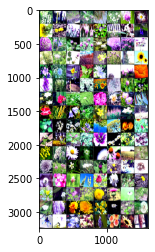

Wild Grape Vine lily_of_the_valley Blue Vervain Forget Me Not castor_oil_plant Coneflower Chicory Curly Dock Queen Annes Lace Cleavers Chicory Chicory Gardenia Daisy Fleabane Purple Deadnettle Blue Vervain Allium Garlic Mustard Burdock Herb Robert Shepherds Purse Chicory Mallow Allium Crithmum Maritimum Spring Beauty Geranium castor_oil_plant lily_of_the_valley Herb Robert Joe Pye Weed Queen Annes Lace Coltsfoot Chickweed Queen Annes Lace Forget Me Not Chickweed Daisy Fleabane Geranium Calendula Alfalfa Lambs Quarters lily_of_the_valley Cowslip Queen Annes Lace Crimson Clover Pickerelweed Gardenia Fireweed foxglove Peppergrass Curly Dock foxglove Red Clover Downy Yellow Violet castor_oil_plant foxglove lily_of_the_valley Garlic Mustard Coltsfoot lily_of_the_valley Fern Leaf Yarrow Fireweed Pineapple Weed Joe Pye Weed Peppergrass Coneflower Borage Prickly Pear Cactus Elderberry Calendula Creeping Charlie Forget Me Not Daisy Fleabane Geranium Joe Pye Weed Coltsfoot Curly Dock Elderberry 

In [11]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(5, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(49 * 4 * 4, 392)
        self.fc2 = nn.Linear(392, 196)
        self.fc3 = nn.Linear(196, 85)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [14]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 1000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.8f}')
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 3.61852847
[1,   200] loss: 2.79863795
[1,   300] loss: 2.49788693
[1,   400] loss: 2.29784945
[2,   100] loss: 2.08771808
[2,   200] loss: 1.96168475
[2,   300] loss: 1.90324909
[2,   400] loss: 1.88702933
[3,   100] loss: 1.72409061
[3,   200] loss: 1.69439234
[3,   300] loss: 1.67661055
[3,   400] loss: 1.61422148
[4,   100] loss: 1.51183219
[4,   200] loss: 1.47730085
[4,   300] loss: 1.44826411
[4,   400] loss: 1.45395051
[5,   100] loss: 1.30830653
[5,   200] loss: 1.33158730
[5,   300] loss: 1.34105060
[5,   400] loss: 1.29975901
[6,   100] loss: 1.18711672
[6,   200] loss: 1.19130835
[6,   300] loss: 1.19018346
[6,   400] loss: 1.19267292
[7,   100] loss: 1.09772389
[7,   200] loss: 1.09351641
[7,   300] loss: 1.09991253
[7,   400] loss: 1.07413606
[8,   100] loss: 0.98753163
[8,   200] loss: 0.99195686
[8,   300] loss: 0.98176532
[8,   400] loss: 0.97139146
[9,   100] loss: 0.88269017
[9,   200] loss: 0.90286735
[9,   300] loss: 0.89333499
[9,   400] loss: 0.8

In [15]:
PATH = './ediharm.pth'
torch.save(net.state_dict(), PATH)

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4))

In [16]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
outputs = net(images)

In [18]:
correct = 0
total = 0

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in validloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predictions = torch.max(outputs, 1)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print(f'Accuracy of the network on the { total } validation images: {(100 * correct // total):.2f} %')

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Validation Accuracy for class: {classname:5s} is {accuracy:.2f} %')

Accuracy of the network on the 2378 validation images: 53.00 %
Validation Accuracy for class: Alfalfa is 44.23 %
Validation Accuracy for class: Allium is 54.17 %
Validation Accuracy for class: Blue Vervain is 40.00 %
Validation Accuracy for class: Borage is 38.00 %
Validation Accuracy for class: Broadleaf Plantain is 0.00 %
Validation Accuracy for class: Bull Thistle is 20.00 %
Validation Accuracy for class: Burdock is 41.30 %
Validation Accuracy for class: Calendula is 80.00 %
Validation Accuracy for class: castor_oil_plant is 50.00 %
Validation Accuracy for class: Cattail is 40.62 %
Validation Accuracy for class: Chickweed is 76.36 %
Validation Accuracy for class: Chicory is 62.22 %
Validation Accuracy for class: Chive Blossom is 20.00 %
Validation Accuracy for class: Cleavers is 81.13 %
Validation Accuracy for class: Coltsfoot is 36.36 %
Validation Accuracy for class: Common Mallow is 60.87 %
Validation Accuracy for class: Common Milkweed is 20.00 %
Validation Accuracy for class: Co

In [19]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

correct = 0
total = 0
# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


print(f'Accuracy of the network on the { total } test images: {(100 * correct // total):.2f} %')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Test Accuracy for class: {classname:5s} is {accuracy:.2f} %')

Accuracy of the network on the 491 test images: 33.00 %
Test Accuracy for class: Alfalfa is 80.00 %
Test Accuracy for class: Allium is 20.00 %
Test Accuracy for class: Blue Vervain is 20.00 %
Test Accuracy for class: Borage is 80.00 %
Test Accuracy for class: Broadleaf Plantain is 0.00 %
Test Accuracy for class: Bull Thistle is 40.00 %
Test Accuracy for class: Burdock is 60.00 %
Test Accuracy for class: Calendula is 80.00 %
Test Accuracy for class: castor_oil_plant is 100.00 %
Test Accuracy for class: Cattail is 60.00 %
Test Accuracy for class: Chickweed is 60.00 %
Test Accuracy for class: Chicory is 20.00 %
Test Accuracy for class: Chive Blossom is 20.00 %
Test Accuracy for class: Cleavers is 40.00 %
Test Accuracy for class: Coltsfoot is 100.00 %
Test Accuracy for class: Common Mallow is 60.00 %
Test Accuracy for class: Common Milkweed is 0.00 %
Test Accuracy for class: Common Sow Thistle is 80.00 %
Test Accuracy for class: Common Vetch is 60.00 %
Test Accuracy for class: Common Yarro

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [21]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=784, out_features=392, bias=True)
  (fc2): Linear(in_features=392, out_features=196, bias=True)
  (fc3): Linear(in_features=196, out_features=85, bias=True)
)

In [22]:
inputs, labels = data[0].to(device), data[1].to(device)